In [ ]:
import requests, re, os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from urllib.request import urlretrieve
from tqdm import tqdm

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor 
from torch.nn import Parameter

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv,to_hetero,GraphConv 
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.loader import LinkNeighborLoader

from transformers import BertTokenizer, BertModel
from extractor import *

# data loading

In [2]:
link_df=pd.read_csv('./data/advertiser_influencer_link.csv',index_col=0)
link_df

,title,advertiser,influencer,date,view,keyword,videoID
0,현 올영알바가 추천하는 향수대신 쓰기 좋은 갓성비 향기템 추천 #올리브영알바 #올영...,더블유드레스룸,유나러부,23.08.26,조회수 3K,뷰티 & 메이크업,VW5HM-wVV08
1,"3배 더 예뻐지는 ""컨투어링"" 멱살 잡고 알려드림✊? | 죽어가는 이목구비 소생법 ...",페리페라,지냐 Jinyaa,23.08.26,조회수 73K,뷰티 & 메이크업,wCjzu3OT2XE
2,갸루 언니✌ to K-아이돌?언니 데뷔해줘요,에뛰드,회사원A,23.08.26,조회수 32K,뷰티 & 메이크업,T8PLbhE6fqc
3,토너 200% 활용법 #토너팩하는법 #더마펌,더마펌,랏뚜 Beauty,23.08.26,조회수 51,뷰티 & 메이크업,olFCmnJ-znY
4,베네피트 신상틴트? 태연PICK 6컬러 발라보기! (스플래시 듀이틴트&플러시 벨벳틴...,베네피트,HANE 하네,23.08.26,조회수 3K,뷰티 & 메이크업,_y9BEWs3obc
...,...,...,...,...,...,...,...
25169,이런거까지 된다는 요즘 로봇청소기 ㄷㄷ,아이리버,공간일기,23.08.28,조회수 8천,IT & 전자기기,dDwK_uvlqh0
25170,미리보는 남자 가을코디 (with 갤럭시 Z 플립5),삼성전자,코디메이커 피로,23.08.27,조회수 4만,IT & 전자기기,6ugZ1JO600o
25171,"ENG) 다이노탱 때문에 백화점 오픈런이라는걸 해봄😱 귀여운 마그넷 만들고, 콩알이...",삼성전자,코지데이 CozyDay,23.08.27,조회수 2만,IT & 전자기기,HHUiqWBWcoA
25172,손 그림 VS 액정 타블렛 ? 뉴진스 하니,엑스피펜,MerryMa 메리마,23.08.26,조회수 1백만,IT & 전자기기,-0JNe3se7JM


In [3]:
influencer_info=pd.read_csv('./data/influencer_info.csv',index_col=0 )
influencer_info

,influencer,keyword,ad_name,subscribers,num_videos,view,clear_subscriber,clear_video,clear_view,average_view,negative,positive
0,areumsongee아름송이,뷰티 & 메이크업 & 패션 & 뷰티,"['나의 결혼계획 발표...타투소개 , 30대의 노화관리(?) 그리고 스무살 송충이...",구독자 80.4만명,266,"조회수 79,082,010회",804000,266,79082010,98.360709,0.165041,0.834959
1,솔업 sollup,패션 & 뷰티 & 코디 & 룩북,['아트가 라이프에 주는 가치에 대해? 아트 컬렉팅을 시작하는 쉬운 방법 공유해요!...,구독자 5.67만명,126,"조회수 3,560,810회",56700,126,3560810,62.800882,0.126663,0.873337
2,에익쿠,만화 & 애니메이션 & 언어,"['ENG) 첫 임무 / MBTI 저승사자 만화 ep.3', 'MBTI 올리브영 할...",구독자 33.1만명,176,"조회수 77,560,785회",331000,176,77560785,234.322613,0.264321,0.735679
3,마빡,게임 & 음식,['경북 성주로 밀웜사육하는곳가서 직접먹방!! [ Mealworm Mukbang ]...,구독자 14.6만명,2.2천,"조회수 47,977,810회",146000,2200,47977810,328.615137,0.434274,0.565726
4,nbkorea,패션 & 뷰티 & 스포츠 의류,['[뉴발란스] New Balance Womens Sports Club with 뉴...,구독자 6.95천명,481,"조회수 16,441,242회",6950,481,16441242,2365.646331,0.032029,0.967971
...,...,...,...,...,...,...,...,...,...,...,...,...
3807,핵꿀잼,"영화 & 교육 & 직업, 언어","['드라마 아니고 영환줄..', '미친 삼각 말아주는 #최악의악', '유재석이 기다...",구독자 16.6만명,1.3천,"조회수 878,905,265회",166000,1300,878905265,5294.610030,0.811188,0.188812
3808,지식인사이드,"의료 & 건강, 신체 질환 & 컨디션 이상 & 재테크","[""EBS 명의 출연 정형외과 전문의, 제 부모님이 무릎 아프다고 하시면 딱 '이것...",구독자 117만명,410,"조회수 194,240,972회",117000,410,194240972,1660.179248,0.316265,0.683735
3809,흥삶이네 Heungsam's Life,식품 & 먹방 & 레시피,"['부모님 모시고 홍천 한우 먹고왔습니다.', '부모님 모시고 군산에 다녀왔습니다....",구독자 6.49만명,27,"조회수 7,276,901회",64900,27,7276901,112.124823,0.270422,0.729578
3810,리뷰하는고래,"IT & 전자기기, 소비자 가전 & 취미 & 공예, 특별한 날","['""왜 안춥지?"" 난방비 절약하는 겨울 꿀템 추천 제품 5가지', '갤럭시도 맥세...",구독자 1.43만명,93,"조회수 18,304,358회",14300,93,18304358,1280.025035,0.520805,0.479195


# create node, edge

In [4]:
unique_advertiser_id = link_df['advertiser'].unique() 
unique_advertiser_id = pd.DataFrame(data={
    'advertiser': unique_advertiser_id,
    'mappedID': pd.RangeIndex(len(unique_advertiser_id)), 
})
print("Mapping of sponsor IDs to consecutive values:")
print("==========================================")
print(unique_advertiser_id.head())



unique_influencer_id = link_df['influencer'].unique()
unique_influencer_id = pd.DataFrame(data={
    'influencer': unique_influencer_id,
    'mappedID': pd.RangeIndex(len(unique_influencer_id)),
})
print("Mapping of creator IDs to consecutive values:")
print("===========================================")
print(unique_influencer_id.head())


Mapping of sponsor IDs to consecutive values:
  advertiser  mappedID
0    더블유드레스룸         0
1       페리페라         1
2        에뛰드         2
3        더마펌         3
4       베네피트         4
Mapping of creator IDs to consecutive values:
  influencer  mappedID
0       유나러부         0
1  지냐 Jinyaa         1
2       회사원A         2
3  랏뚜 Beauty         3
4    HANE 하네         4


In [5]:
rating_advertiser_id = pd.merge(link_df['advertiser'], unique_advertiser_id,
                            left_on='advertiser', right_on='advertiser', how='left')
print(rating_advertiser_id)
rating_advertiser_id = torch.from_numpy(rating_advertiser_id['mappedID'].values)
print(rating_advertiser_id)
print(len(rating_advertiser_id))


      advertiser  mappedID
0        더블유드레스룸         0
1           페리페라         1
2            에뛰드         2
3            더마펌         3
4           베네피트         4
...          ...       ...
25169       아이리버      1885
25170       삼성전자      1039
25171       삼성전자      1039
25172       엑스피펜      1040
25173       삼성전자      1039

[25174 rows x 2 columns]
tensor([   0,    1,    2,  ..., 1039, 1040, 1039])
25174


In [6]:
rating_influencer_id = pd.merge(link_df['influencer'], unique_influencer_id,
                            left_on='influencer', right_on='influencer', how='left')
print(rating_influencer_id)
rating_influencer_id = torch.from_numpy(rating_influencer_id['mappedID'].values)
print(rating_influencer_id)
print(len(rating_influencer_id))


            influencer  mappedID
0                 유나러부         0
1            지냐 Jinyaa         1
2                 회사원A         2
3            랏뚜 Beauty         3
4              HANE 하네         4
...                ...       ...
25169             공간일기      3811
25170         코디메이커 피로      1454
25171     코지데이 CozyDay      1254
25172      MerryMa 메리마      1692
25173  쥬캔버스 JOO CANVAS      1691

[25174 rows x 2 columns]
tensor([   0,    1,    2,  ..., 1254, 1692, 1691])
25174


In [7]:
edge_index_advertiser_to_influencer = torch.stack([rating_advertiser_id, rating_influencer_id], dim=0)
print(len(edge_index_advertiser_to_influencer)) 
print(len(edge_index_advertiser_to_influencer[0])) 

assert edge_index_advertiser_to_influencer.size() == (2, len(edge_index_advertiser_to_influencer[0]))
print()
print("Final edge indices pointing from sponsors to creators:")
print("=================================================")
print(edge_index_advertiser_to_influencer) 

2
25174

Final edge indices pointing from sponsors to creators:
tensor([[   0,    1,    2,  ..., 1039, 1040, 1039],
        [   0,    1,    2,  ..., 1254, 1692, 1691]])


# create edge weight

In [9]:
advertiser_dict = dict()
influencer_dict = dict()
edge_list = list()
edge_list_dict=dict()


for idx, advertiser in enumerate(sorted(set(link_df["advertiser"].values))):
    advertiser_dict[advertiser] = idx

for idx, influencer in enumerate(sorted(set(link_df["influencer"].values))):
    influencer_dict[influencer] = idx


for advertiser, influencer in link_df[["advertiser", "influencer"]].values:
    if (advertiser, influencer) not in edge_list:
        edge_list.append((advertiser, influencer))
        edge_list_dict[(advertiser, influencer)]=1
    else:
        edge_list_dict[(advertiser, influencer)]=edge_list_dict[(advertiser, influencer)]+1
    
    

reversed_advertiser_dict = {value: key for key, value in advertiser_dict.items()}
reversed_influencer_dict = {value: key for key, value in influencer_dict.items()}

In [10]:
for i in range(len(edge_list)):
    if list(edge_list_dict.keys())[i]==edge_list[i]:
        pass
    else:
        print(i)


In [11]:
weight_feature=[]
for i in range(len(link_df)):
    pair=[]
    pair.append(link_df['advertiser'][i])
    pair.append(link_df['influencer'][i])
    weight_value=edge_list_dict[tuple(pair)]
    weight_feature.append(weight_value)
    
weight_feature=torch.tensor(weight_feature)

# feature extraction

In [ ]:
#create advertiser keyword feature, run this code to get advertiser keyword feature.
advertiser_feature=[]
for i in range(len(unique_advertiser_id)):
    each = unique_advertiser_id['advertiser'][i]
    length = len(link_df[link_df['advertiser']==each]['keyword'].unique())
    if length==1:
        advertiser_feature.append(link_df[link_df['advertiser']==each]['keyword'].unique()[0])
    elif length==2:
        advertiser_feature.append(link_df[link_df['advertiser']==each]['keyword'].unique()[0]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[1])
    elif length==3:
        advertiser_feature.append(link_df[link_df['advertiser']==each]['keyword'].unique()[0]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[1]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[2])
        
    elif length==4:
        advertiser_feature.append(link_df[link_df['advertiser']==each]['keyword'].unique()[0]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[1]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[2]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[3])
        
    else:
        advertiser_feature.append(link_df[link_df['advertiser']==each]['keyword'].unique()[0]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[1]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[2]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[3]+' & '+link_df[link_df['advertiser']==each]['keyword'].unique()[4])
    
    
    
# Load KoBERT model ,tokenizer
kobert_model_name = "monologg/kobert"
tokenizer = BertTokenizer.from_pretrained(kobert_model_name)
model = BertModel.from_pretrained(kobert_model_name)
corpus_embeddings = []

for sentence in tqdm(advertiser_feature):
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    corpus_embeddings.append(sentence_embedding)

#advertiser_embeddings=corpus_embeddings
advertiser_embeddings = corpus_embeddings
advertiser_embeddings = np.array(advertiser_embeddings)
np.save('./advertiser_keyword.npy', advertiser_embeddings)

In [ ]:
# creator influencer keyword feature, run this code to get influencer keyword feature.

influencer_feature=[]
for i in range(len(unique_influencer_id)):
    each=unique_influencer_id['influencer'][i]
    key=influencer_info[influencer_info['influencer']==each]['keyword'].item()
    influencer_feature.append(key)
    
kobert_model_name = "monologg/kobert"
tokenizer = BertTokenizer.from_pretrained(kobert_model_name)
model = BertModel.from_pretrained(kobert_model_name)
inf_corpus_embeddings = []

for sentence in tqdm(influencer_feature):
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    inf_corpus_embeddings.append(sentence_embedding)
    
inf_corpus_embeddings=np.array(inf_corpus_embeddings)
np.save('./influencer_keyword.npy', inf_corpus_embeddings)

In [ ]:
# create profile_image feature, run this code to get profile image feature

clear_name=[]
for i in range(len(unique_influencer_id)):
    title_name = re.sub('[^0-9a-zA-Zㄱ-힗]', '', unique_influencer_id['creator'][i]) 
    clear_name.append(title_name)
    
img_list = []

for img_title in tqdm(clear_name):
    img_path='./datafolder/profile/'
    
    if img_path+img_title+'.jpg' in glob(img_path+'/*'):
        image = np.array(Image.open(img_path+img_title+'.jpg').convert("RGB").resize((224, 224))) 
        img_list.append(image)    
        
# CNN model
cnnmodel = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten()
])


img_feature = cnnmodel.predict(img_list)
print(img_feature.shape)


In [12]:
# load advertisr keyword.npy file

advertiser_keyword = np.load('./data/advertiser_keyword.npy')
advertiser_keyword=advertiser_keyword.tolist()
advertiser_keyword=torch.tensor(advertiser_keyword)
advertiser_keyword=advertiser_keyword.reshape(1886,768)

advertiser_keyword.shape

torch.Size([1886, 768])

In [13]:
# load influencer keyword.npy file
influencer_keyword = np.load('./data/influencer_keyword.npy')
influencer_keyword=influencer_keyword.tolist()
influencer_keyword=torch.tensor(influencer_keyword)
influencer_keyword=influencer_keyword.reshape(3812,768)
influencer_keyword.shape

torch.Size([3812, 768])

In [14]:
# extract subscriber_rank feature
subscribe_num=influencer_info['clear_subscriber']
subscriber_rank=rankify_10(subscribe_num)
subscriber_rank

tensor([6., 1., 3.,  ..., 1., 1., 1.])

In [15]:
# extract video_rank feature
clear_video_num=influencer_info['clear_video']
video_rank=rankify_10(clear_video_num)
video_rank

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [16]:
# extract view_rank feature
clear_view=influencer_info['clear_view']
view_rank=rankify_10(clear_view)
view_rank

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [17]:
# extract average_view feature
average_view=[]
for i in range(len(influencer_info['clear_view'])):
    average_view.append(influencer_info['clear_view'][i]/influencer_info['clear_subscriber'][i])
average_view=list(influencer_info['average_view'])
int_list = [float(item) for item in average_view]
average_view=torch.tensor(int_list)

In [18]:
# extract average_view_byvideo feature
average_view_byvideo=[]
for i in range(len(influencer_info['clear_view'])):
    average_view_byvideo.append(influencer_info['clear_view'][i]/influencer_info['clear_video'][i])
int_list = [float(item) for item in average_view_byvideo]
average_view_byvideo=torch.tensor(int_list)

In [19]:
# extract average_view_rank feature
average_view_num=average_view
average_view_rank=rankify_10(average_view_num)
average_view_rank

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [20]:
# extract average_view_byvideo_rank feature
average_view_byvideo_num=average_view_byvideo
average_view_byvideo_rank=rankify_10(average_view_byvideo_num)
average_view_byvideo_rank        

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [21]:
# extract neg_rank, pos_rank feature
comment_data=influencer_info[['influencer','negative','positive']]

unique_influencer_id
neg=[]
pos=[]

for i in unique_influencer_id['influencer']:

    neg.append(comment_data[comment_data['influencer']==i]['negative'].item())
    pos.append(comment_data[comment_data['influencer']==i]['positive'].item())
    
neg=torch.tensor(neg)
pos=torch.tensor(pos)

neg_rank=rankify_5(pos)
neg_rank    

pos_rank=rankify_5(pos)
pos_rank

tensor([5., 5., 5.,  ..., 4., 3., 2.])

In [24]:
# profile image feature
img_feature=np.load('./data/profile_image.npy')
img_feature=torch.tensor(img_feature)

In [25]:
img_feature=img_feature
influencer_keyword=influencer_keyword
subscriber_rank=subscriber_rank.reshape(3812,1)
video_rank=video_rank.reshape(3812,1)
view_rank=view_rank.reshape(3812,1)
average_view=average_view.reshape(3812,1)
average_view_byvideo=average_view_byvideo.reshape(3812,1)
average_view_rank=average_view_rank.reshape(3812,1)
average_view_byvideo_rank=average_view_byvideo_rank.reshape(3812,1)
neg=neg.reshape(3812,1)
pos=pos.reshape(3812,1)
neg_rank=neg_rank.reshape(3812,1) 
pos_rank=pos_rank.reshape(3812,1) 


# graph construction

In [26]:
data = HeteroData()
data["advertiser"].node_id = torch.arange(len(unique_advertiser_id)) # user 의 노드 아이디를 user 수로
data["influencer"].node_id = torch.arange(len(influencer_info)) # movie 의 노드 아이디를 movie 수로 

influencer_feature = torch.cat((img_feature,influencer_keyword,subscriber_rank,video_rank,average_view_rank,average_view_byvideo_rank,neg_rank), dim=-1)#,neg.reshape(3788,1),pos.reshape(3788,1))

data = HeteroData()
data["advertiser"].node_id = torch.arange(len(unique_advertiser_id)) 
data["influencer"].node_id = torch.arange(len(unique_influencer_id)) 
data["advertiser"].x = advertiser_keyword 
data["influencer"].x = influencer_feature 
data["advertiser", "interest", "influencer"].edge_index = edge_index_advertiser_to_influencer 
data["advertiser", "interest", "influencer"].edge_weight=weight_feature
print(data)


data = T.ToUndirected()(data) # 양방향으로 정보를 전달할 수 있도록 역방향 edge 추가 


HeteroData(
  advertiser={
    node_id=[1886],
    x=[1886, 768],
  },
  influencer={
    node_id=[3812],
    x=[3812, 837],
  },
  (advertiser, interest, influencer)={
    edge_index=[2, 25174],
    edge_weight=[25174],
  }
)


# training setting

In [27]:
# random link split 
torch.manual_seed(827)
transform = T.RandomLinkSplit( 
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("advertiser", "interest", "influencer"),
    rev_edge_types=("influencer", "rev_interest", "advertiser"), 
)
train_data, val_data, test_data = transform(data)

# train loader setting
edge_label_index = train_data["advertiser", "interest", "influencer"].edge_label_index
edge_label = train_data["advertiser", "interest", "influencer"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[30,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("advertiser", "interest", "influencer"), edge_label_index),
    edge_label=edge_label,
    batch_size=256,
    shuffle=True
)

In [28]:
# define GNN 
class GNN(torch.nn.Module):
        def __init__(self, hidden_channels):
            super().__init__()

            self.conv1 = GraphConv(hidden_channels, hidden_channels,aggr  = 'mean' , edge_weight=weight_feature)
            self.conv2 = GraphConv(hidden_channels, hidden_channels,aggr  = 'mean', edge_weight=weight_feature)
        def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
            x = F.relu(self.conv1(x, edge_index))
            x = self.conv2(x, edge_index)
            x = self.conv2(x, edge_index)


            return x


class Classifier(torch.nn.Module):

    def forward(self, x_advertiser: Tensor, x_influencer: Tensor, edge_label_index: Tensor) -> Tensor:


        edge_feat_advertiser = x_advertiser[edge_label_index[0]]
        edge_feat_influencer = x_influencer[edge_label_index[1]] 

        return (edge_feat_advertiser * edge_feat_influencer).sum(dim=-1) 



class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        

        self.advertiser_lin = torch.nn.Linear((data['advertiser'].x).shape[1], hidden_channels) 
        self.influencer_lin = torch.nn.Linear((data['influencer'].x).shape[1], hidden_channels) 

        self.advertiser_emb = torch.nn.Embedding(data["advertiser"].num_nodes, hidden_channels)
        self.influencer_emb = torch.nn.Embedding(data["influencer"].num_nodes, hidden_channels)




        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
        "advertiser": self.advertiser_lin(data["advertiser"].x) + self.advertiser_emb(data["advertiser"].node_id),
        "influencer": self.influencer_lin(data["influencer"].x) + self.influencer_emb(data["influencer"].node_id)
        } 


        x_dict = self.gnn(x = x_dict, edge_index = data.edge_index_dict)

        pred = self.classifier(
            x_dict["advertiser"],
            x_dict["influencer"],
            data["advertiser", "interest", "influencer"].edge_label_index )
        return pred


# train GNN-IR

In [30]:
model = Model(hidden_channels=64)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for epoch in tqdm(range(100)):
    total_loss = total_examples = 0
    for sampled_data in train_loader:
        weight_feature=sampled_data["advertiser", "interest", "influencer"]['edge_weight']
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["advertiser", "interest", "influencer"].edge_label
        ground_truth=ground_truth.float()

        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    val_preds = []
    val_ground_truths = []

    val_data.to(device)
    val_preds.append(model(val_data))
    weight_feature=val_data["advertiser", "interest", "influencer"]['edge_weight']
    val_ground_truths.append(val_data["advertiser", "interest", "influencer"].edge_label)

    val_pred = torch.cat(val_preds, dim=0).detach().cpu().numpy()
    val_ground_truth = torch.cat(val_ground_truths, dim=0).detach().cpu().numpy()



    pred_tensor = torch.from_numpy(val_pred).to(device) 
    probabilities = torch.sigmoid(pred_tensor).cpu().numpy() 

    auc = roc_auc_score(val_ground_truth, probabilities)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


# evaluate GNN-IR

In [31]:
# test_loader setting
edge_label_index = test_data["advertiser", "interest", "influencer"].edge_label_index
edge_label = test_data["advertiser", "interest", "influencer"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[30, 10],
    edge_label_index=(("advertiser", "interest", "influencer"), edge_label_index),
    edge_label=edge_label,
    batch_size=256,
    shuffle=False,
)
sampled_data = next(iter(test_loader))

# evaluate model using test data
preds = []
nn=0
ground_truths = []
ground_starts =[]
ground_ends =[]
for sampled_data in test_loader:

    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))   

        ground_starts.append(sampled_data["advertiser", "interest", "influencer"].edge_label_index[0]) 
        ground_ends.append(sampled_data["advertiser", "interest", "influencer"].edge_label_index[1]) 
        ground_truths.append(sampled_data["advertiser", "interest", "influencer"].edge_label)


pred = torch.cat(preds, dim=0).cpu().numpy() 
pred_tensor = torch.from_numpy(pred).to(device)  
probabilities = torch.sigmoid(pred_tensor).cpu().numpy() 

ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
ground_start = torch.cat(ground_starts, dim=0).cpu().numpy() 
ground_end = torch.cat(ground_ends, dim=0).cpu().numpy()
roc_auc = roc_auc_score(ground_truth, probabilities)

result_df=pd.DataFrame()
result_df['start']=ground_start
result_df['end']=ground_end
result_df['proba']=probabilities
result_df['ground_truth']=ground_truth

pred_value=[]
for i in range(len(result_df)):
    if result_df.iloc[i]['proba']>=0.5:
        pred_value.append(1.0)
    else:
        pred_value.append(0.0)

result_df['pred_value']=pred_value

auc=accuracy_score(ground_truth, pred_value)
precision=precision_score(ground_truth, pred_value, average='binary')
recall=recall_score(ground_truth, pred_value, average='binary')
f1=f1_score(ground_truth, pred_value, average='binary')


print(f'roc_auc값: {roc_auc}')
print(f'auc 값:{auc}')
print(f'precision 값: {precision}')
print(f'recall 값:{recall}')
print(f'f1 값:{f1}')

roc_auc값: 0.9473739872008996
auc 값:0.8910078135346312
precision 값: 0.886052871467639
recall 값:0.7723480333730631
f1 값:0.8253024835491402


# precision@k

In [32]:
total_precision=[]
real=result_df[:2517]
precision_list=[]
real_uni=real['start'].unique() 
# get precision@k
for k in range(1,11):
    realk=[]
    for m in range(len(real_uni)):
        if len(real[real['start']==real_uni[m]])>=k: 
            realk.append(real_uni[m])
    for i in range(len(realk)):
        a=result_df[result_df['start']==realk[i]]
        topk_indices = a['proba'].nlargest(k).index
        b=result_df.iloc[topk_indices]
        zero=0
        recommendk=b['end'].tolist()    
        for j in range(len(recommendk)):
            one_collection=a[a['ground_truth']==1.0]           
            if recommendk[j] in one_collection['end'].tolist():
                zero+=1
        total_precision.append(zero/k)
    print(f'precision@{k} : {sum(total_precision)/len(total_precision)}') 
    precision_list.append(sum(total_precision)/len(total_precision))

        


precision@1 : 0.9705882352941176
precision@2 : 0.9732142857142857
precision@3 : 0.9706078824315303
precision@4 : 0.9672213817448314
precision@5 : 0.9624035728786022
precision@6 : 0.9576190476190479
precision@7 : 0.9532116635200353
precision@8 : 0.9482882283348137
precision@9 : 0.9438701499118198
precision@10 : 0.9402106362258209


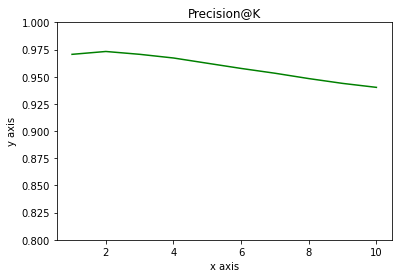

In [33]:
# visualize precision@k
x = np.arange(1,11)
y = np.array(precision_list)

plt.xlabel('x axis')
plt.ylabel('y axis')
plt.ylim([0.8, 1.0])
plt.plot(x,y,'g')
plt.title('Precision@K')
plt.show()


# recall@k

In [34]:
total_recall=[]
recall_list=[]
real=result_df[:2517]
real_uni=real['start'].unique()
for m in range(1,11):
    k=m
    realk=[]
    for i in range(len(real_uni)):
        a=result_df[result_df['start']==real_uni[i]]       
        topk_indices = a['proba'].nlargest(k).index 
        b=result_df.iloc[topk_indices]
        zero=0
        recommendk=b['end'].tolist()
        for j in range(len(recommendk)):
            one_collection=a[a['ground_truth']==1.0]
            if recommendk[j] in one_collection['end'].tolist():
                zero+=1
        total_recall.append(zero/len(one_collection))
    print(f'recall@{k} : {sum(total_recall)/len(total_recall)}')  
    recall_list.append(sum(total_recall)/len(total_recall))

recall@1 : 0.09319504041537878
recall@2 : 0.1369743345183971
recall@3 : 0.17875895568045055
recall@4 : 0.21762535104064704
recall@5 : 0.2536278683541011
recall@6 : 0.28803041846577443
recall@7 : 0.32103009041940656
recall@8 : 0.35339983878952075
recall@9 : 0.38501379384654283
recall@10 : 0.4151538141174619


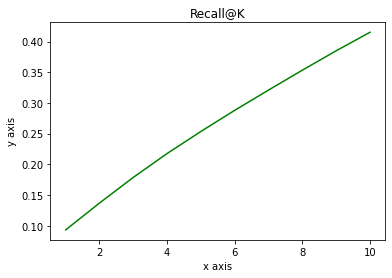

In [35]:
# visualize recall@k
x = np.arange(1,11)
y = np.array(recall_list)
plt.plot(x,y,'g')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('Recall@K')
plt.show()
